# Dynamically Adaptable Virtual Machines for Sustainable Websites

This notebook aim at providing the analysis process of our paper

## Imports

In [68]:
import json 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
from math import sqrt
import scipy.stats as stats
import scipy.special as special

## Website Carbon

This script aim to provide the energy consumption and carbon impact of website requests.

### Constants

In [69]:
# Path to the folder containing HAR files
HAR_FOLDER = "./Data_Transfer/"

# Algorithm constants
KWG_PER_GB = 1.805
KWH_PER_BYTE = KWG_PER_GB / 1073741824
J_PER_KWH = 1000 * 3600
RETURNING_VISITOR_PERCENTAGE = 0.75
FIRST_TIME_VIEWING_PERCENTAGE = 0.25
PERCENTAGE_OF_DATA_LOADED_ON_SUBSEQUENT_LOAD = 0.02
CARBON_PER_KWG_GRID = 475
CARBON_PER_KWG_RENEWABLE = 33.4
PERCENTAGE_OF_ENERGY_IN_DATACENTER = 0.1008
PERCENTAGE_OF_ENERGY_IN_TRANSMISSION_AND_END_USER = 0.8992
CO2_GRAMS_TO_LITRES = 0.5562

# Data access constants
NORMAL = 0
ADAPTED = 1

### Functions

adjustDataTranfert : calculate the average transfert size considering caching capacity of web browser

energyConsumption : calculate the energy consumption from the tranfert size

getCo2Grid : calculate the equivalent CO2 when using a classic host

getCo2Renewable : calculate the equivalent CO2 when using a green host

co2ToLitres : convert CO2 mass to volume

getStatistics : aggregate previous statistics

cleanerThan : compare to other sites

In [70]:
def adjustDataTransfer(val): 
    out =  val * RETURNING_VISITOR_PERCENTAGE 
    out += val * PERCENTAGE_OF_DATA_LOADED_ON_SUBSEQUENT_LOAD * FIRST_TIME_VIEWING_PERCENTAGE
    return out

In [71]:
def energyConsumption(bytes): 
    return bytes * KWH_PER_BYTE;

In [72]:
def getCo2Grid(energy):
    return energy * CARBON_PER_KWG_GRID;

In [73]:
def getCo2Renewable(energy):
    out =  energy * PERCENTAGE_OF_ENERGY_IN_DATACENTER * CARBON_PER_KWG_RENEWABLE
    out += energy * PERCENTAGE_OF_ENERGY_IN_TRANSMISSION_AND_END_USER * CARBON_PER_KWG_GRID
    return out

In [74]:
def co2ToLitres(co2):
    return co2 * CO2_GRAMS_TO_LITRES;

In [75]:
def getStatistics(bytes):
    bytesAdjusted = adjustDataTransfer(bytes);
    energy = energyConsumption(bytesAdjusted);
    co2Grid = getCo2Grid(energy);
    co2Renewable = getCo2Renewable(energy);

    return {
        'adjustedBytes' : bytesAdjusted,
        'energy' : energy,
        'co2' : {
            'grid' : {
                'grams' : co2Grid,
                'litres': co2ToLitres(co2Grid)
            },
            'renewable' : {
                'grams' : co2Renewable,
                'litres' : co2ToLitres(co2Renewable)
            }
        }
    }

In [76]:
def cleanerThan(co2):
    # This array needs to be updated periodically with new data. This was
    # originally calculated with a database query but that was too slow at
    # scale. We can look in to writing a cron job that will generate and export
    # from the database once a month, that is then loaded in this file.

    # This array was last generated with rankings/index.php on 27/01/2020
    percentiles = [0.00126957622871866,0.004035396817140881,0.012595561048805604,0.023304715095553624,0.036438786824583,0.050362397616329,0.064014899640461,0.077739052678226,0.092126836186624,0.10757047217165,0.125027739890344,0.140696302455872,0.15929047315768,0.177734818869488,0.19581439489964,0.21422507361825607,0.232736823359142,0.246082174332492,0.264348156430992,0.28306902111392,0.30180466482882,0.320295382181204,0.33950686554985604,0.360111566931774,0.38114308483189,0.40185357017186396,0.42035354145420606,0.4393550630164101,0.458541453493762,0.47918906703882,0.499654077413412,0.521285635156174,0.5405494875603221,0.56161428648152,0.58238456980151,0.604316363860106,0.6256429617179278,0.6478269528228661,0.6691073942929641,0.68867154881184,0.7103787320465419,0.7331362414675519,0.7562483364936439,0.780892842691506,0.80396830015467,0.8269877794821401,0.85060546199698,0.874387816802448,0.899691291111552,0.92324242726303,0.9511826145960923,0.976586133398462,1.002258239346,1.02822903453074,1.0566669431626,1.08448123862022,1.1130571798008,1.1446436812039398,1.17548103245766,1.2075157831423,1.2419762271574795,1.27780212823068,1.31343697309996,1.3535322129548801,1.3963404885134,1.43538821676594,1.4786819721653202,1.52287253339568,1.5710404823845998,1.6176354301871,1.6627899659050596,1.71503331661196,1.7731704594157403,1.8271314036959998,1.8888232850004,1.9514501162933802,2.01843049142384,2.08929918752446,2.1680425684300615,2.2538809089543,2.347435716407921,2.44446281762258,2.551568006854039,2.6716183180923796,2.8030676779506,2.947526052684458,3.1029734241542397,3.2801577012624605,3.4659335564053406,3.6858566410374,3.9539822299055203,4.2833358140900835,4.686514950833381,5.167897618200399,5.7413021838327,6.52500051792535,7.628926245040858,9.114465674521588,12.30185529895519,92.584834950345]

    for i in range(0, 100):
        value = percentiles[i]
        if(co2 < value):
            return (100 - i)
    return 0

In [77]:
def printInfo(bytesNb):
  stats = getStatistics(bytesNb)
  energy = stats["energy"]
  grams = stats["co2"]["grid"]["grams"]
  greenerThan = cleanerThan(grams)
  if(greenerThan > 50):
      print("\033[1;32;48mThis page is cleaner than " + str(greenerThan) + "% of web pages tested\033[00m")
  else:
      print("\033[1;31;48mThis page is dirtier than " + str(99-greenerThan) + "% of web pages tested\033[00m")
  print("\033[01m"+str(round(grams,3)) + "g of CO2\033[00m is produced every time someone visits this web page ("+str(round(energy,4))+" KWH)")

### Data

Build the datastructure from the HAR files

In [78]:
HAR_FILES = glob.glob(HAR_FOLDER+"*.har")

data = []

for HAR_FILE in HAR_FILES:
    normal = open(HAR_FILE, "r")
    adapted = open(HAR_FILE+".adapted", "r")
    if normal.mode == 'r' and adapted.mode == 'r':
        contents = normal.read()
        jsonObj = json.loads(contents)
        normal_bytes = 0
        for r in jsonObj["log"]["entries"]:
            normal_bytes += r["response"]["bodySize"]

        contents = adapted.read()
        jsonObj = json.loads(contents)
        adapted_bytes = 0
        for r in jsonObj["log"]["entries"]:
            adapted_bytes += r["response"]["bodySize"]
      
        entry = {
            "name": HAR_FILE, 
            "transferSizes" : [normal_bytes, adapted_bytes],
            "energy" : [energyConsumption(normal_bytes) * J_PER_KWH, energyConsumption(adapted_bytes) * J_PER_KWH]
        }
        data.append(entry)

## Approach consumption



### Node.js Proxy consumption

In [79]:
proxy_consumption = pd.read_csv('./proxy/NodeProxy.csv', header=None) 
proxy_consumption = proxy_consumption.groupby(0).sum()
proxy_consumption = proxy_consumption / 100

### HTML VM Consumption

In [80]:
vm_consumption = pd.read_csv('./proxy/HTML.csv', header=None) 
vm_consumption = vm_consumption.groupby(0).sum()
vm_consumption = vm_consumption / 10

In [81]:
approach_consumption = []
for index, row in proxy_consumption.iterrows():
    parts = index.split(".")
    entry = { "name" : parts[0], "energy" : row[1]}
    approach_consumption.append(entry)
for index, row in vm_consumption.iterrows():
    parts = index.split(".")
    entry = { "name" : parts[0], "energy" : row[1]}
    approach_consumption.append(entry)
    
approach_consumption = pd.DataFrame(approach_consumption)

In [82]:
approach_consumption = approach_consumption.groupby("name").sum()
approach_average_consumption = gmean(approach_consumption.loc[:,"energy"])
print("Geometric mean of energy consumption = " + str(approach_average_consumption))

Geometric mean of energy consumption = 68.61082178391608


## Statistics


In [83]:
def cohend_1sample(d, expected_mean):
    n = len(d)
    s= np.std(d, ddof=(n-1))
    return (np.mean(d) - expected_mean) / s

### Website Carbon

./Data_Transfer/y2mate.har : -0.08677476648909965
./Data_Transfer/genius.har : 0.8624504306315708
./Data_Transfer/britannica.har : 0.9283621885808455
./Data_Transfer/spanishdict.har : 0.9074974863499278
./Data_Transfer/dailymail.har : 0.9001955972857368
./Data_Transfer/premierleague.har : 0.7248139078801875
./Data_Transfer/espncricinfo.har : 0.7599236450974477
./Data_Transfer/theguardian.har : 0.5611738517747926
./Data_Transfer/amazon.har : 0.09654623123999273
./Data_Transfer/fandom.har : 0.9288959718128857
./Data_Transfer/uptodown.har : 0.9681865052409672
./Data_Transfer/yelp.har : 0.7262748963057455
./Data_Transfer/apple.har : 0.35446465120392023
./Data_Transfer/yahoo.har : 0.9066042633576699
./Data_Transfer/globo.har : 0.7889168964224141
./Data_Transfer/playstation.har : 0.10924049432464122
./Data_Transfer/tripadvisor.har : 0.9502624908658479
./Data_Transfer/dictionary.har : 0.9186287386460963
./Data_Transfer/techradar.har : 0.09801245305426809
./Data_Transfer/craiglist.har : 0.7368

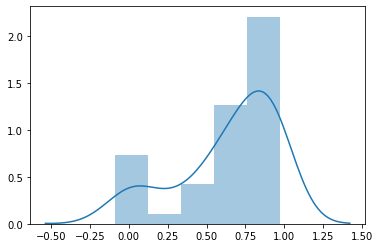

In [99]:
ratios= []
diffs = []
for entry in data:
    ratio = 1 - (entry["energy"][ADAPTED] + approach_average_consumption) / entry["energy"][NORMAL]
    #if ratio < 0:
    print(entry["name"] + " : " + str(ratio))
    ratios.append(ratio)
    diffs.append(entry["energy"][NORMAL] - entry["energy"][ADAPTED] - approach_average_consumption)
dfRatios = pd.DataFrame(ratios)
dfDiffs  = pd.DataFrame(diffs)
print("\n\nRATIOS :")
print(dfRatios.describe())
print("\nDIFF(J) :")
print(dfDiffs.describe())

sns.distplot(ratios, norm_hist=True);


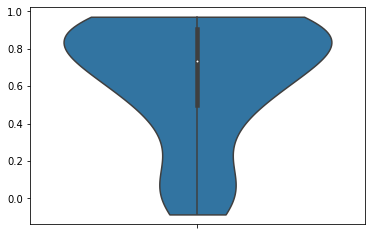

In [104]:
sns.violinplot(y=ratios, cut=0)

In [85]:
t, p = stats.ttest_1samp(a=ratios, popmean=0)
mean = np.mean(ratios)
lo, hi = stats.t.interval(0.95, df=(len(ratios) - 1), loc=mean, scale=stats.sem(ratios))
print("Estimated mean : " + str(mean) + " with p-value : " + str(p))
print("Confidence interval : [" + str(lo) + ", " + str(hi) + "] delta = " + str(mean - lo))
print("Effect size (Cohen's d) : " + str(cohend_1sample(ratios, 0)))

Estimated mean : 0.6380081851540493 with p-value : 4.155311923174705e-17
Confidence interval : [0.5418878756441818, 0.7341284946639168] delta = 0.0961203095098675
Effect size (Cohen's d) : 0.3006303071691179


In [86]:
t, p = stats.ttest_1samp(a=diffs, popmean=0)
mean = np.mean(diffs)
lo, hi = stats.t.interval(0.95, df=(len(diffs) - 1), loc=mean, scale=stats.sem(diffs))
print("Estimated mean : " + str(mean) + " with p-value : " + str(p))
print("Confidence interval : [" + str(lo) + ", " + str(hi) + "] delta = " + str(mean - lo))
print("Effect size (Cohen's d) : " + str(cohend_1sample(diffs, 0)))

Estimated mean : 17894.929801553117 with p-value : 7.140212245790405e-08
Confidence interval : [12310.824126676936, 23479.035476429297] delta = 5584.10567487618
Effect size (Cohen's d) : 0.14514365037925192




Control Group :
                   0
count      45.000000
mean    25762.320914
std     21795.906832
min      1225.022273
25%     10053.600602
50%     25756.101614
75%     29630.597278
max    113707.568955
0    3249.141954
dtype: float64

Test Group :
                  0
count     45.000000
mean    7867.391112
std     9773.922140
min      348.576144
25%     1876.875020
50%     3642.946527
75%     9453.397979
max    43804.898555
0    1457.010287
dtype: float64


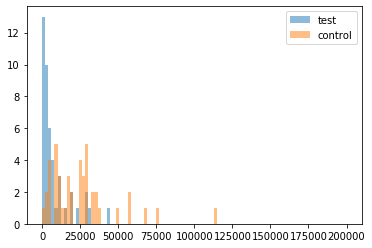

In [87]:
control= []
test = []
for entry in data:
    control.append(entry["energy"][NORMAL])
    test.append(entry["energy"][ADAPTED] + approach_average_consumption)
dfControl = pd.DataFrame(control)
dfTest  = pd.DataFrame(test)
print("\n\nControl Group :")
print(dfControl.describe())
print(dfControl.sem())
print("\nTest Group :")
print(dfTest.describe())
print(dfTest.sem())


bins = np.linspace(100, 200000, 100)

plt.hist(test, bins, alpha=0.5, label='test')
plt.hist(control, bins, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.show()

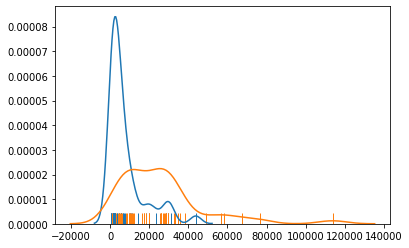

In [88]:
sns.distplot(test, hist=False, bins=20, rug=True);
sns.distplot(control, hist=False, bins=20, rug=True);

In [89]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [90]:
print("Effect size : " + str(cohend(control, test)))
stats.ttest_ind(a=control,b=test,equal_var=False)

Effect size : 1.0594549561745572


Ttest_indResult(statistic=5.025436109798207, pvalue=4.676455520870763e-06)

In [91]:
def fieller(d1, d2, p):
    a, b = np.mean(d1), np.mean(d2)
    sa, sb = pd.DataFrame(d1).sem().get(0), pd.DataFrame(d2).sem().get(0)
    (r, _) = stats.pearsonr(d1, d2)
    t = special.stdtrit(len(d1) + len(d2) - 2, 1-p)

    cov = np.cov([d1,d2])
    print(cov)
    
    va = sa * sa
    vb = sb * sb
    cov = r * sa * sb
    s2 = va/(b*b) - (2*a)/(b*b*b)*cov + (a*a)/(b*b*b*b)*vb
    s = sqrt(s2)
    g = t * t * s2 * vb /(b * b)
    
    
    ratio = a / b
    ratio2 = ratio * ratio
    
    factor = 1 / (1 - g)
    base = ratio - g * cov/vb
    
    
    two  = 2.0 * ratio * cov
    sqr  = ratio2 * vb
    gfac = g * (va - cov * cov / vb)
    sqrt_under = va - two + sqr - gfac
    delt = (t * s / b) * sqrt(sqrt_under)

    low  = factor * (base - delt)
    high = factor * (base + delt)

    return (low, high)

In [92]:
fieller(test, control, 0.05)

[[9.55295540e+07 1.12560197e+08]
 [1.12560197e+08 4.75061555e+08]]


(0.30143399054109415, 0.3093475950639981)